# Chapter 05 — Cell Ranger Filtered Cell Typing

### Objective

In this chapter, we load the AnnDatas that we saved in the last chapter, and use CellTypist to transefer cell type labels onto tissues that have an associated model. For tissues that don't have a matching model, we perform manual cell typing by averaging gene expression across clusters and scoring the aggregated transcriptome based on marker gene expression.

This includes:

- Reading in AnnDatas from the correct input directory
- Running CellTypist on tissues that have matching models
- Aggregating gene expression and assigning gene signature scores based on marker genes
- Plotting marker gene dotplots, heatmaps, and UMAPs to confirm that programmatic cell typing makes sense
- Plotting cell type annotations by protocol in order to identify whether one protocol captures more/different cell types than others
- Using InferCNVpy on tumor samples in order to identify tumor/normal samples - this requires annotating chromosomal locations for genes based on relevant genome GTF file

#### Tissues and Annotation Method

> **FILL IN HERE**  
> Include what tissues you will be analyzing and what methods you'll be using for the analysis

> **EXAMPLE (DELETE THIS SECTION BEFORE FINALIZING):**
>  
> - Normal Liver: CellTypist, "Healthy_Human_Liver.pkl"
> - Normal Colon: Manual cell type annotations using aggregated gene expression by cluster. Marker genes from (Moorman et. al 2025)
> - Tumor Colon: Manual cell type annotations using aggregated gene expression by cluster. Marker genes from (Moorman et. al 2025). InferCNVpy for tumor cell annotation


---
### Data Inputs and Outputs

- AnnDatas will come from "adatas/combined_adatas_filtered_cells_clusters_removed"
- Combined (by tissue) AnnDatas will be outputed to "adatas/combined_adatas_filtered_cells_clusters_removed_with_cell_type"
- Figures will be outputted to "figures/chapter_05_cell_ranger_filtered_cell_typing

##### Run Autoreload (Automically Reloads Edited Module Files)

In [1]:
%load_ext autoreload
%autoreload 2

#### Imports

In [66]:
import os
import gzip

import celltypist
import infercnvpy as cnv
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import math

import utils
import utils.config as config

### File Paths

In [5]:
# File and directory paths
figures_output_dir = config.FIGURES_DIR / "chapter_05_cell_ranger_filtered_cell_typing"
input_adata_dir = config.ADATA_DIR / "combined_adatas_filtered_cells_clusters_removed"
output_adata_dir = config.ADATA_DIR / "combined_adatas_filtered_cells_clusters_removed_with_cell_type"

# Make sure output directories exist
os.makedirs(figures_output_dir, exist_ok=True)
os.makedirs(output_adata_dir, exist_ok=True)

### Read in AnnDatas

In [6]:
# Load AnnData objects
combined_by_tissue_adata_dict = {}
sample_metadata = config.SAMPLES_METADATA
tissue_order = config.TISSUE_ORDER

for tissue in tissue_order:
    file_path = os.path.join(
        input_adata_dir,
        f"{tissue.replace(' ', '_')}_combined_adata_clusters_removed.h5ad",
    )

    adata = sc.read_h5ad(file_path)
    combined_by_tissue_adata_dict[tissue] = adata
    print(f"{tissue}: {adata}")

Normal Colon: AnnData object with n_obs × n_vars = 11247 × 18667
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping', 'doublet_score', 'predicted_doublet', 'protocol', 'tissue', 'sample', 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'downsampled_umi', 'raw_data'
    obsp: 'connectivities', 'distances'
Tumor Colon: AnnData object with n_obs × n_vars = 13958 × 18948
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_cou

## Cell Typing

#### Functions

- filter_marker_genes_by_adata: Filters a dictionary of marker genes by gene symbols that can be found in an inputted AnnData
- assign_celltypes_by_cluster_avg_expression: Averages expression of marker genes per leiden cluster, then uses this to assign scores to each cell type - the largest score is used to label all cells in that cluster
- plot_umap_markers: Plots subplots for marker gene expression UMAPs

In [46]:
def filter_marker_genes_by_adata(marker_dict: dict, adata: sc.AnnData) -> dict:
    """
    Filters a marker gene dictionary to include only genes present in adata.var_names,
    and prints genes that are not found.

    Args:
        marker_dict: Dictionary mapping cell types to lists of marker genes.
        adata: AnnData object whose var_names will be used to filter genes.

    Returns:
        A new dictionary with only valid genes per cell type.
    """
    valid_genes = set(adata.var_names)
    filtered_dict = {}

    for celltype, genes in marker_dict.items():
        found_genes = [gene for gene in genes if gene in valid_genes]
        missing_genes = [gene for gene in genes if gene not in valid_genes]

        if missing_genes:
            print(f"Cell type '{celltype}': Missing genes -> {missing_genes}")

        filtered_dict[celltype] = found_genes

    return filtered_dict

def assign_celltypes_by_cluster_avg_expression(
    adata: sc.AnnData,
    cell_marker_genes: dict,
    cluster_key: str = "leiden",
) -> None:
    """
    Assigns a cell type to each cluster based on average expression of marker genes.

    Args:
        adata: Annotated data matrix (AnnData object).
        cell_marker_genes: Dict mapping cell types to marker gene lists.
        cluster_key: Key in `adata.obs` corresponding to cluster labels (e.g., 'leiden').

    Modifies:
        adata.obs["predicted_cell_type"]: Cluster-level cell type assignment.
    """
    # Set data matrix
    expr = adata.X
    gene_names = adata.var_names

    # Compute cluster-wise average expression
    clusters = adata.obs[cluster_key].astype(str)
    cluster_names = clusters.unique()

    cluster_means = []
    for cluster in cluster_names:
        idx = (clusters == cluster).values  # convert to NumPy array for sparse indexing
        avg_expr = np.asarray(expr[idx].mean(axis=0)).flatten()
        cluster_means.append(avg_expr)

    cluster_means = pd.DataFrame(
        cluster_means,
        index=cluster_names,
        columns=gene_names,
    )

    # Score each cluster for each cell type
    scores = {}
    for cell_type, markers in cell_marker_genes.items():
        valid_genes = [g for g in markers if g in cluster_means.columns]
        if not valid_genes:
            continue
        scores[cell_type] = cluster_means[valid_genes].mean(axis=1)

    scores_df = pd.DataFrame(scores)
    predicted = scores_df.idxmax(axis=1)

    # Map prediction back to each cell
    adata.obs["predicted_cell_type"] = clusters.map(predicted)
    return


def plot_umap_markers(adata, marker_dict, n_cols=4, figsize_per_plot=(6, 5), **kwargs):
    """
    Plots UMAP subplots for each marker gene in a given dictionary.
    
    Args:
        adata (AnnData): Annotated data matrix (with computed UMAP).
        marker_dict (dict): Dictionary mapping cell types to marker genes.
        n_cols (int): Number of columns in the subplot grid.
        figsize_per_plot (tuple): Size of each subplot (width, height).
        **kwargs: Additional arguments passed to sc.pl.umap.
        
    Returns:
        None (displays the figure).
    """
    
    n_markers = len(marker_dict)
    n_rows = math.ceil(n_markers / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_per_plot[0] * n_cols,
                                                      figsize_per_plot[1] * n_rows))
    axes = axes.flatten()
    
    for i, (cell_type, gene) in enumerate(marker_dict.items()):
        ax = axes[i]
        sc.pl.umap(
            adata,
            color=gene,
            title=f"{cell_type} Marker ({gene})",
            legend_loc="right margin",
            palette="tab20",
            frameon=True,
            vmax="p99.9",
            sort_order=True,
            ax=ax,
            show=False,
            **kwargs
        )
    
    # Remove extra axes if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    return fig

### Marker Genes per Tissue

In [56]:
liver_marker_dict = {
    "Hepatocytes": [
        "APOB",
        "CYP3A4",
    ],  # https://www.nature.com/articles/s42003-022-04046-9
    "Cholangiocytes": [
        "KRT19",
        "CFTR",
    ],  # https://pmc.ncbi.nlm.nih.gov/articles/PMC4315871/
    "Endothelial cells": [
        "PECAM1",
        "CDH5",
        "LDB2",
        "PTPRB",
        "CD31"
    ],  # https://www.nature.com/articles/s41467-022-30633-9, CELL x GENE
    "Fibroblasts": [
        "COL1A2",
        "COL5A2",
        "COL6A3",
    ],  # https://pmc.ncbi.nlm.nih.gov/articles/PMC7444611/, CELL x Gene
    "Macrophages": [
        "CD68",
        "C1QA",
        "C1QB",
        "C1QC",
    ],  # https://pmc.ncbi.nlm.nih.gov/articles/PMC10153153/, https://pmc.ncbi.nlm.nih.gov/articles/PMC10849641/
    "Resident NK": [
        "KLRD1",
        "NCAM1",
    ],  # https://www.ncbi.nlm.nih.gov/gene/3824, https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2017.00892/full
    "T cells": [
        "CD3D",
        "CD3E",
        "CD3G",
        "CD2",
    ],  # https://pubmed.ncbi.nlm.nih.gov/39029632/
    "B cells": [
        "BANK1",
        "IGHM",
        "CD19",
        "CD20",
        "CD79A",
        "CD79B",
    ],  # BANK1 (B cell scaffold protein), IGHM is part of B cell receptor (IgM), CD19 and CD20 were not expressed in enough cells and were filtered out
}

# Marker genes for UMAP visualization
liver_marker_genes_for_umap = {
    "Hepatocyte": "CYP3A4",
    "Endothelial": "PTPRB",
    "Fibroblast": "COL1A2",
    "Cholangiocyte": "KRT19",
    "Macrophage": "CD68",
    "B cell": "BANK1",
    "Resident NK": "KLRD1",
    "T cell": "CD3D",
}

# All marker genes here are from (Moorman et al, 2025)
colon_marker_dict = {
    "Epithelial": ["EPCAM", "KRT8", "KRT18"],
    "Stromal": ["COL6A2", "COL6A1", "PLVAP", "COL1A1"],
    "Immune": [
        "PTPRC",
        "CD3E",
        "CD2",
        "CD3D",
        "CD3G",
        "FCER1G",
        "CSF1R",
        "CD14",
        "CD68",
        "CD38",
    ],
}

# Marker genes for UMAP visualization
colon_marker_genes_for_umap = {
    "Epithelial": "EPCAM",
    "Stromal": "COL6A2",
    "Immune": "PTPRC",
    "Cancer/Stem Cell Marker": "LGR5",
}

### Tissue 1: Normal Liver

Because there's a matching CellTypist model for this tissue, we'll be using CellTypist for cell typing here. Be sure to confirm that the outputs of CellTypist make sense. We've curated a list of marker genes from the literature in order to do the confirmation, but always remember that this a critical step that must be taken.

In [ ]:
# Gather AnnData to analyse
normal_liver_cell_typist_input = combined_by_tissue_adata_dict["Normal Liver"].copy()

# CellTypist works on raw data that is normalized to 10_000 reads per cell.
normal_liver_cell_typist_input.X = normal_liver_cell_typist_input.layers[
    "raw_data"
].copy()
sc.pp.normalize_total(normal_liver_cell_typist_input, target_sum=1e4, inplace=True)
sc.pp.log1p(normal_liver_cell_typist_input)

#### Download Relevant CellTypist Model

In [11]:
# Download the CellTypist model for Healthy Human Liver
celltypist.models.download_models(force_update=True, model="Healthy_Human_Liver.pkl")

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /home/ghoshr/.celltypist/data/models
💾 Total models to download: 1
💾 Downloading model [1/1]: Healthy_Human_Liver.pkl


##### Perform CellTypist Annotation

In [15]:
# Perform cell typing using CellTypist
liver_cell_predictions = celltypist.annotate(
    normal_liver_cell_typist_input,
    model="Healthy_Human_Liver.pkl",
    majority_voting=True,
    over_clustering="leiden",
)

# Convert predictions to AnnData
liver_cell_predictions_adata = liver_cell_predictions.to_adata()

🔬 Input data has 13315 cells and 19719 genes
🔗 Matching reference genes in the model
🧬 2279 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


##### Plot Resulting UMAP with Cell Type Annotations

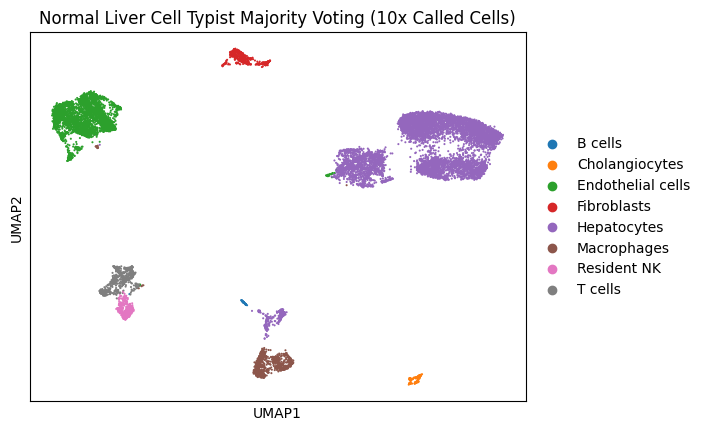

In [16]:
# Plot the results
fig = sc.pl.umap(
    liver_cell_predictions_adata,
    color="majority_voting",
    title="Normal Liver Cell Typist Majority Voting (10x Called Cells)",
    return_fig=True,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "normal_liver_majority_voting_output.png"), bbox_inches="tight"
)

### Normal Liver Marker Gene Analysis

##### Normal Liver Marker Gene Dotplot

Cell type 'Endothelial cells': Missing genes -> ['CD31']
Cell type 'B cells': Missing genes -> ['CD19', 'CD20', 'CD79A', 'CD79B']


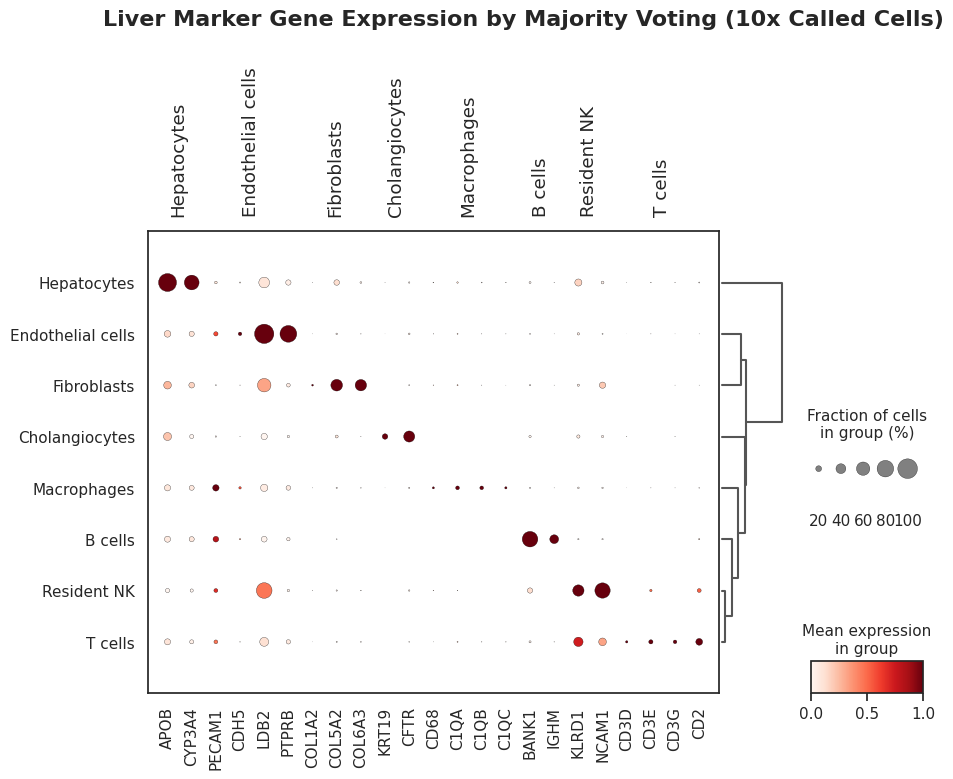

In [39]:
# Filter marker genes by AnnData object
filtered_liver_marker_dict = filter_marker_genes_by_adata(
    marker_dict=liver_marker_dict,
    adata=liver_cell_predictions_adata,
)

# Create the dotplot
liver_dp = sc.pl.dotplot(
    liver_cell_predictions_adata,
    var_names=filtered_liver_marker_dict,
    groupby="majority_voting",
    standard_scale="var",
    color_map="Reds",
    figsize=(10, 6),
    dendrogram=True,
    show=False,
    return_fig=True,
)

# Set title and adjust layout
fig = liver_dp.get_axes()["mainplot_ax"].figure
fig.suptitle(
    "Liver Marker Gene Expression by Majority Voting (10x Called Cells)",
    fontsize=16,
    weight="bold",
    y=1.25,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
fig.savefig(os.path.join(figures_output_dir, "normal_liver_marker_gene_dotplot.png"))

##### Normal Liver Marker Gene Heatmap

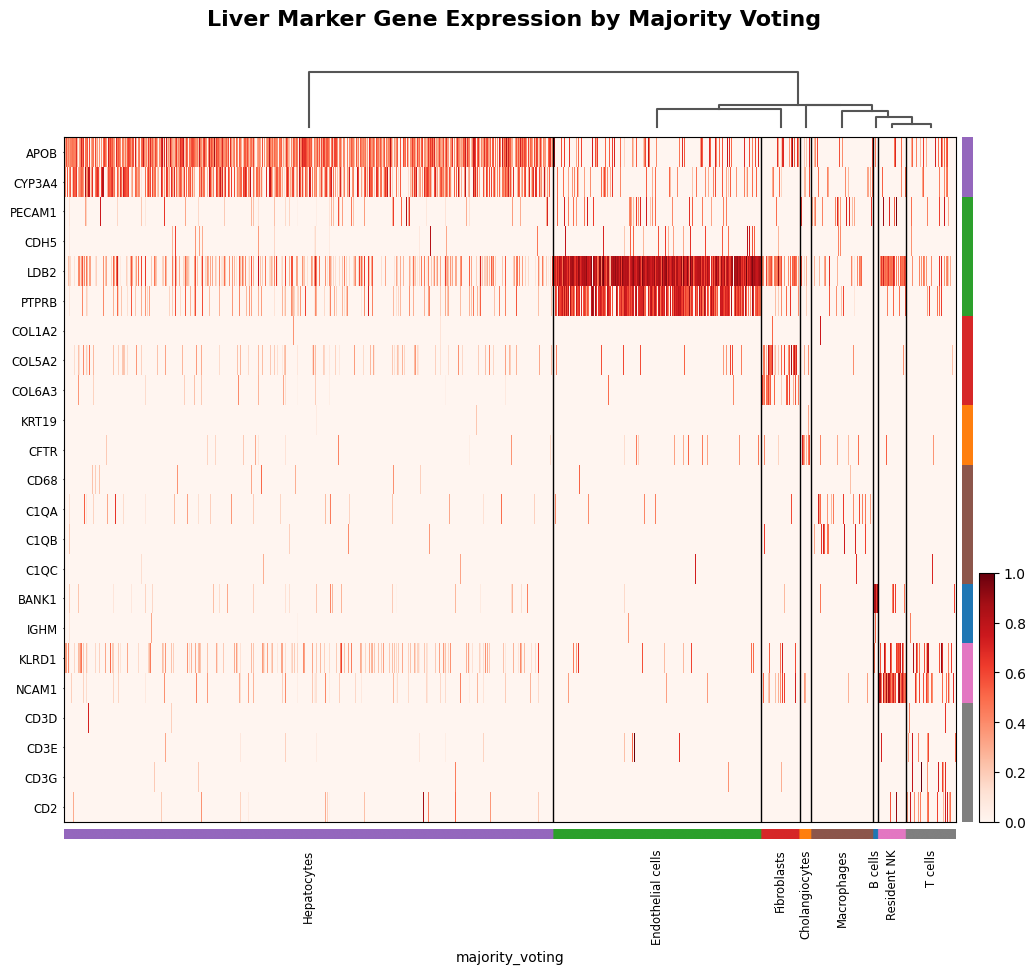

In [21]:
# Create and store the heatmap object
liver_hm = sc.pl.heatmap(
    liver_cell_predictions_adata,
    var_names=filtered_liver_marker_dict,
    groupby="majority_voting",
    use_raw=False,
    standard_scale="var",
    cmap="Reds",
    swap_axes=True,
    show_gene_labels=True,
    var_group_rotation=90,
    var_group_labels=liver_marker_dict.keys(),
    dendrogram=True,
    figsize=(12, 10),
    show=False,
)

# Use any axis to get the figure
fig = next(iter(liver_hm.values())).figure

# Set suptitle and adjust layout
fig.suptitle(
    "Liver Marker Gene Expression by Majority Voting",
    fontsize=16,
    weight="bold",
    y=0.94,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "normal_liver_marker_gene_heatmap.png"),
    bbox_inches="tight",
)

##### Marker Gene UMAPs

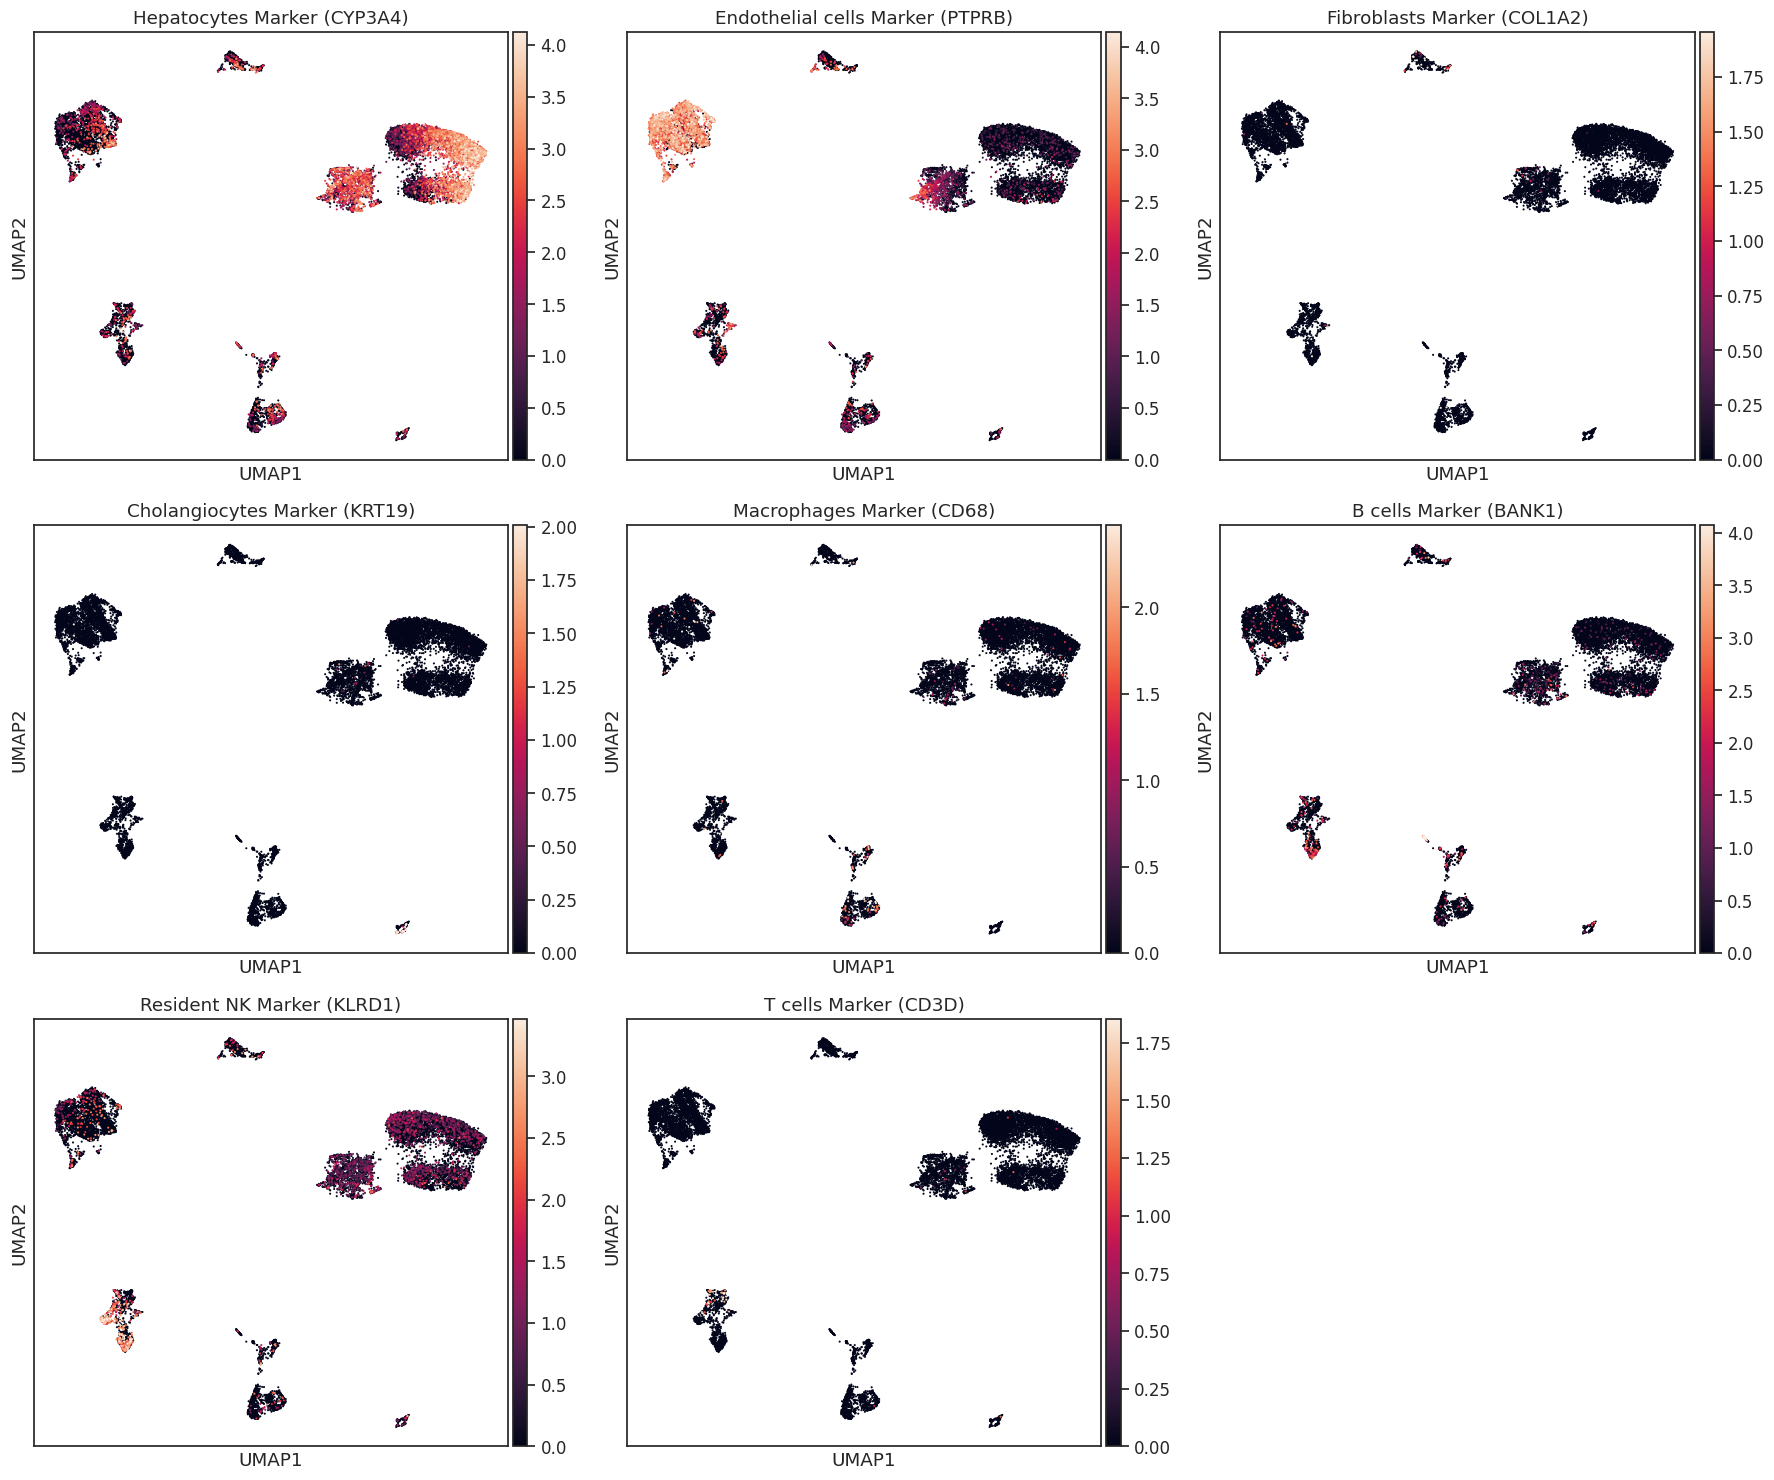

In [54]:
# Plot UMAPs for marker genes
fig = plot_umap_markers(liver_cell_predictions_adata, liver_marker_genes_for_umap, n_cols=3)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "normal_liver_marker_gene_umaps.png"),
    bbox_inches="tight",
)

##### Normal Liver Cell Type by Protocol (Percentage)

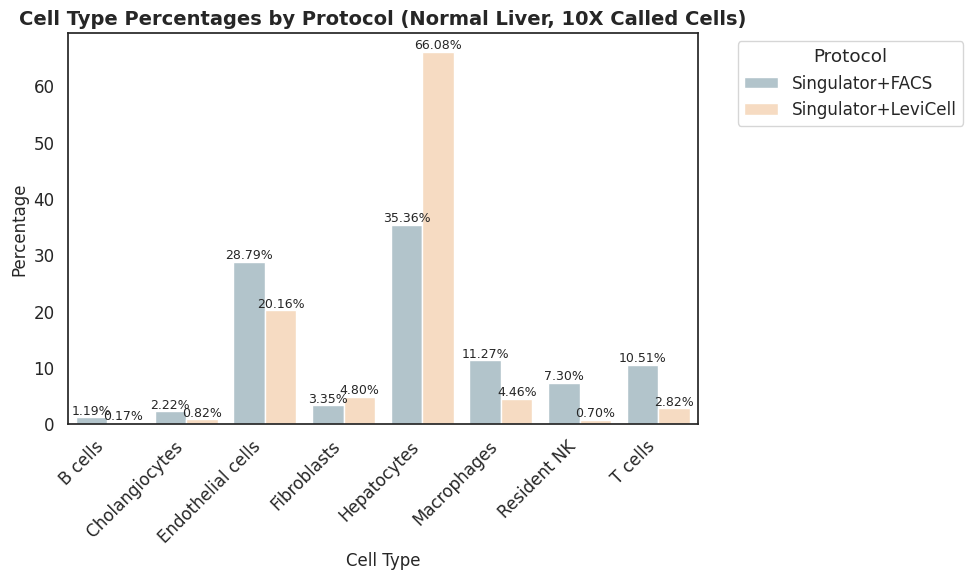

In [24]:
protocol_color_palette = config.PROTOCOL_COLOR_PALETTE

# Plot cell type proportions by protocol for Normal Liver
fig = utils.plot_celltype_proportions_by_protocol(
    adata=liver_cell_predictions_adata,
    tissue="Normal Liver",
    protocol_color_palette=protocol_color_palette,
    annotate=True,
    percentage=True,
    title="Cell Type Percentages by Protocol (Normal Liver, 10X Called Cells)",
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "normal_liver_cell_type_percentages.png"),
    bbox_inches="tight",
)

##### Normal Liver Cell Type by Protocol (Percentage)

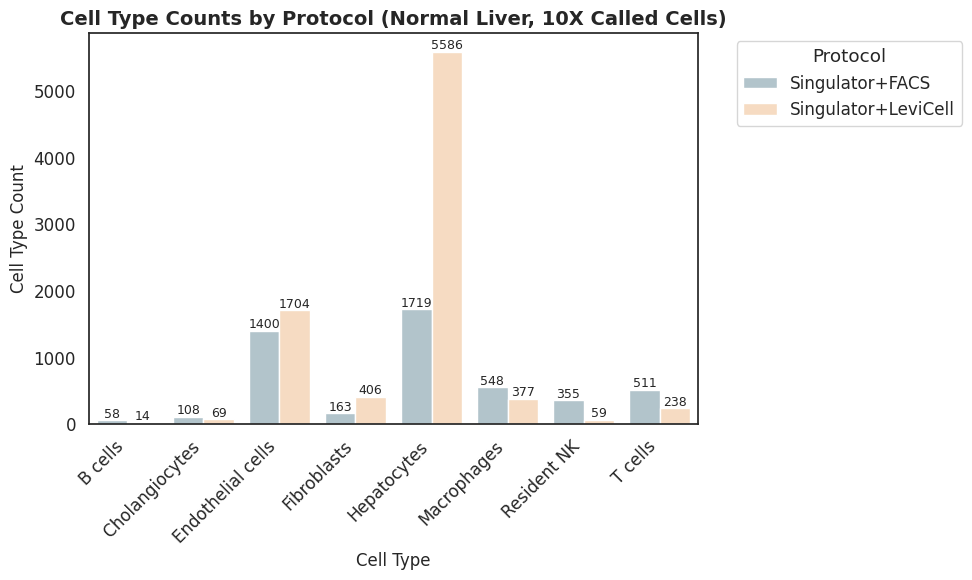

In [25]:
# Plot cell type proportions by protocol for Normal Liver
fig = utils.plot_celltype_proportions_by_protocol(
    adata=liver_cell_predictions_adata,
    tissue="Normal Liver",
    protocol_color_palette=protocol_color_palette,
    annotate=True,
    percentage=False,
    title="Cell Type Counts by Protocol (Normal Liver, 10X Called Cells)",
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "normal_liver_cell_type_total_counts.png"),
    bbox_inches="tight",
)

##### Write Updated AnnData to file

In [ ]:
liver_adata_output_file_path = os.path.join(
    output_adata_dir, "Normal_Liver_combined_adata_clusters_removed_with_cell_type.h5ad"
)
liver_cell_predictions_adata.obs["predicted_cell_type"] = (
    liver_cell_predictions_adata.obs["a"]
)

# Write the updated AnnData to file
liver_cell_predictions_adata.write(liver_adata_output_file_path)

print(f"Updated AnnData with cell type predictions saved to {liver_adata_output_file_path}")

AnnData object with n_obs × n_vars = 13315 × 19719
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping', 'doublet_score', 'predicted_doublet', 'protocol', 'tissue', 'sample', 'n_genes', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap', 'log1p', 'majority_voting_colors', 'dendrogram_majority_voting'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'downsampled_umi', 'raw_data'
    obsp: 'connectivities', 'distances'

### Tissue 2: Normal Colon

Since there is no matching CellTypist model for this tissue, we'll be performing out own manual cell typing for this tissue. Be sure to confirm from this analysis make sense. We've curated a list of marker genes from the literature in order to do the confirmation, but always remember that this a critical step that must be taken.

... storing 'predicted_cell_type' as categorical


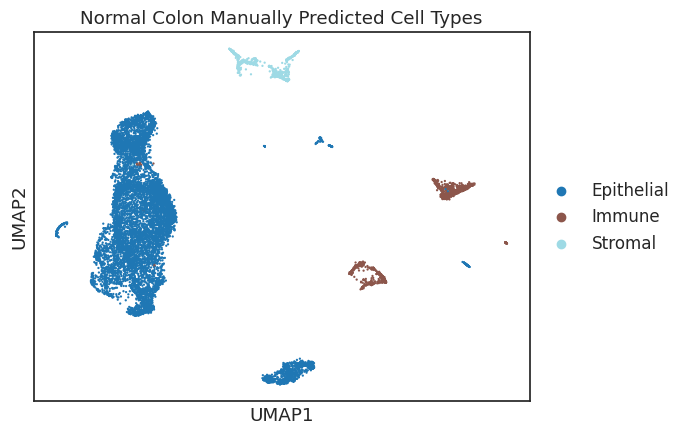

In [31]:
# Get the Normal Colon AnnData
normal_colon_adata = combined_by_tissue_adata_dict["Normal Colon"].copy()

# Assign cell types to the colon adata
assign_celltypes_by_cluster_avg_expression(
    adata=normal_colon_adata,
    cell_marker_genes=colon_marker_dict,
    cluster_key="leiden",
)

# Plot UMAP with predicted cell types for Normal Colon
sc.pl.umap(
    normal_colon_adata,
    color="predicted_cell_type",
    title="Normal Colon Manually Predicted Cell Types",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
)

#### Add Leiden Cluster + Predicted Cell Type Column and Sort for Dotplot

In [32]:
# Create a new column for leiden cell type with predicted cell type
normal_colon_adata.obs["leiden_cell_type"] = (
    normal_colon_adata.obs["leiden"].astype(str)
    + " ("
    + normal_colon_adata.obs["predicted_cell_type"].astype(str)
    + ")"
)


# Sort categories by cell type first, then by leading numeral
def sort_key(cat_name):
    leiden_num = int(cat_name.split(" (")[0])
    cell_type = cat_name.split(" (")[1].rstrip(")")
    return (cell_type, leiden_num)


# Sort the leiden_cell_type categories
current_categories = normal_colon_adata.obs["leiden_cell_type"].unique()
sorted_categories = sorted(current_categories, key=sort_key)
normal_colon_adata.obs["leiden_cell_type"] = pd.Categorical(
    normal_colon_adata.obs["leiden_cell_type"],
    categories=sorted_categories,
    ordered=True,
)

##### Normal Colon Dotplot

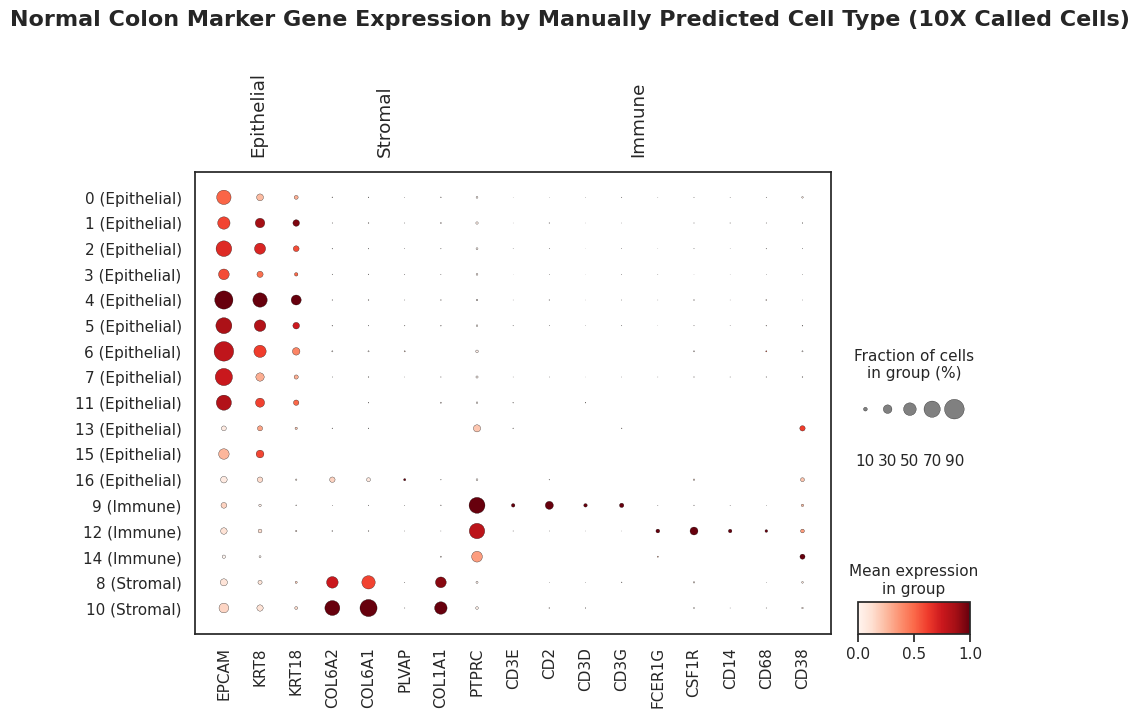

In [33]:
# Filter marker genes by AnnData object
filtered_colon_marker_dict = filter_marker_genes_by_adata(
    marker_dict=colon_marker_dict,
    adata=normal_colon_adata,
)

# Create the dotplot
normal_colon_dp = sc.pl.dotplot(
    normal_colon_adata,
    var_names=filtered_colon_marker_dict,
    groupby="leiden_cell_type",
    standard_scale="var",
    color_map="Reds",
    figsize=(10, 6),
    dendrogram=False,
    show=False,
    return_fig=True,
)

# Set title and adjust layout
fig = normal_colon_dp.get_axes()["mainplot_ax"].figure
fig.suptitle(
    "Normal Colon Marker Gene Expression by Manually Predicted Cell Type (10X Called Cells)",
    fontsize=16,
    weight="bold",
    y=1.15,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
fig.savefig(os.path.join(figures_output_dir, "normal_colon_marker_gene_dotplot.png"))

##### Normal Colon Marker Gene Heatmap

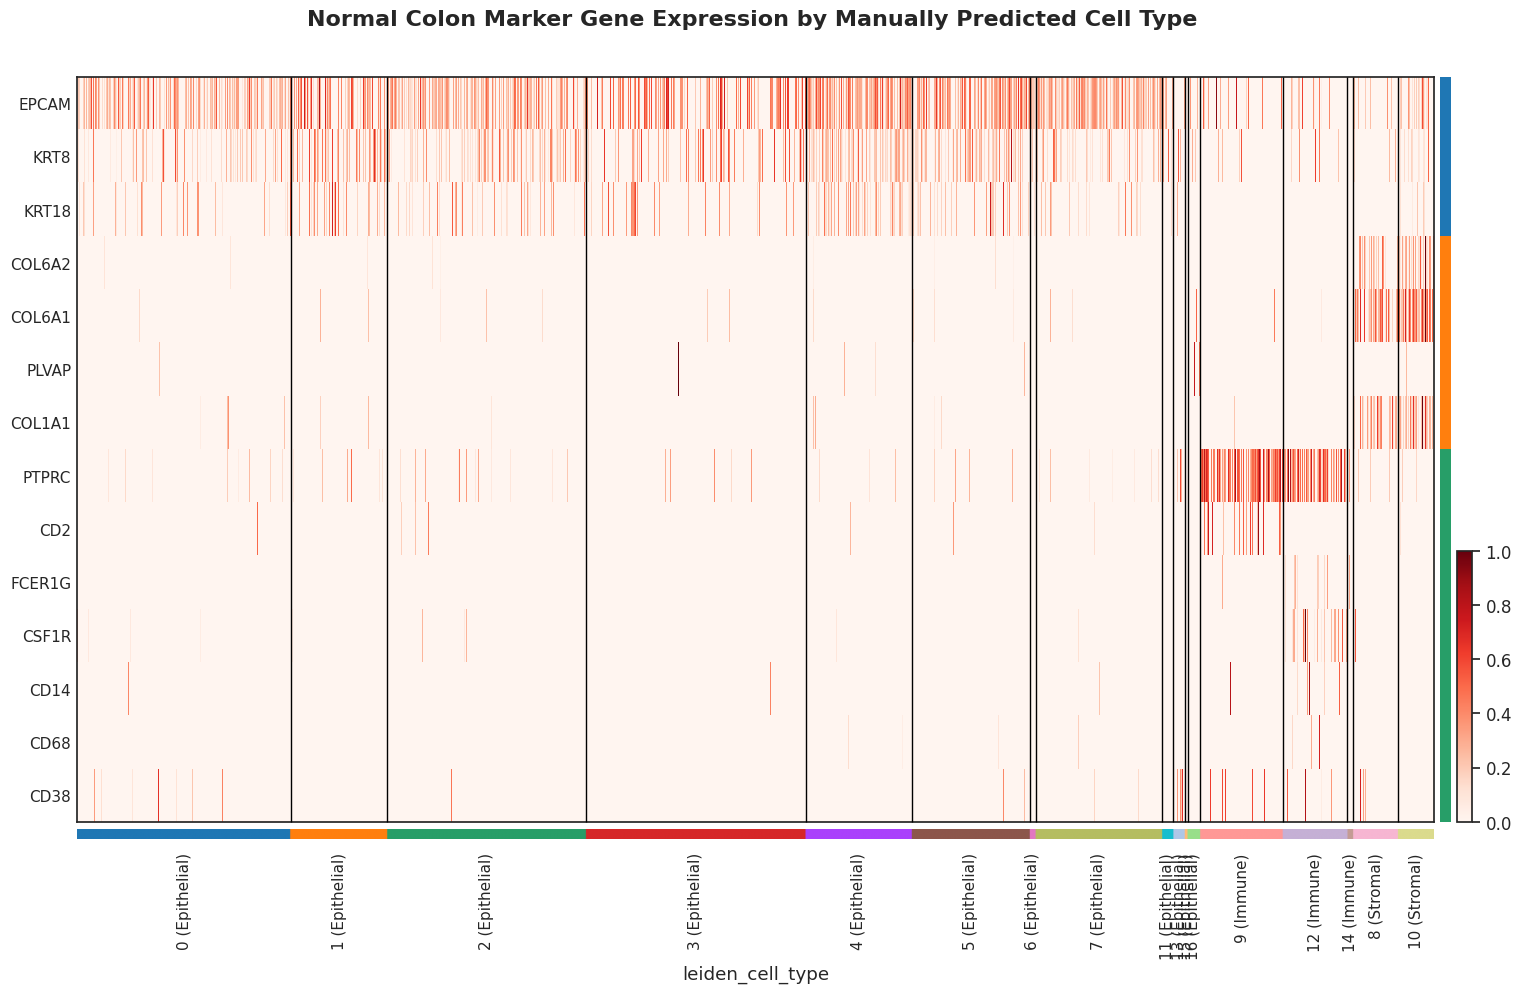

In [63]:
# Create and store the heatmap object
normal_colon_hm = sc.pl.heatmap(
    normal_colon_adata,
    var_names=filtered_colon_marker_dict,
    groupby="leiden_cell_type",
    standard_scale="var",
    cmap="Reds",
    swap_axes=True,
    show_gene_labels=True,
    var_group_labels=filtered_colon_marker_dict.keys(),
    var_group_rotation=45,
    dendrogram=False,
    figsize=(18, 10),
    show=False,
    
)

# Use any axis to get the figure
fig = next(iter(normal_colon_hm.values())).figure

# Set suptitle and adjust layout
fig.suptitle(
    "Normal Colon Marker Gene Expression by Manually Predicted Cell Type",
    fontsize=16,
    weight="bold",
    y=0.94,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "normal_colon_marker_gene_heatmap.png"),
    bbox_inches="tight",
)

#### Plot Normal Colon Marker Gene Expression UMAPs

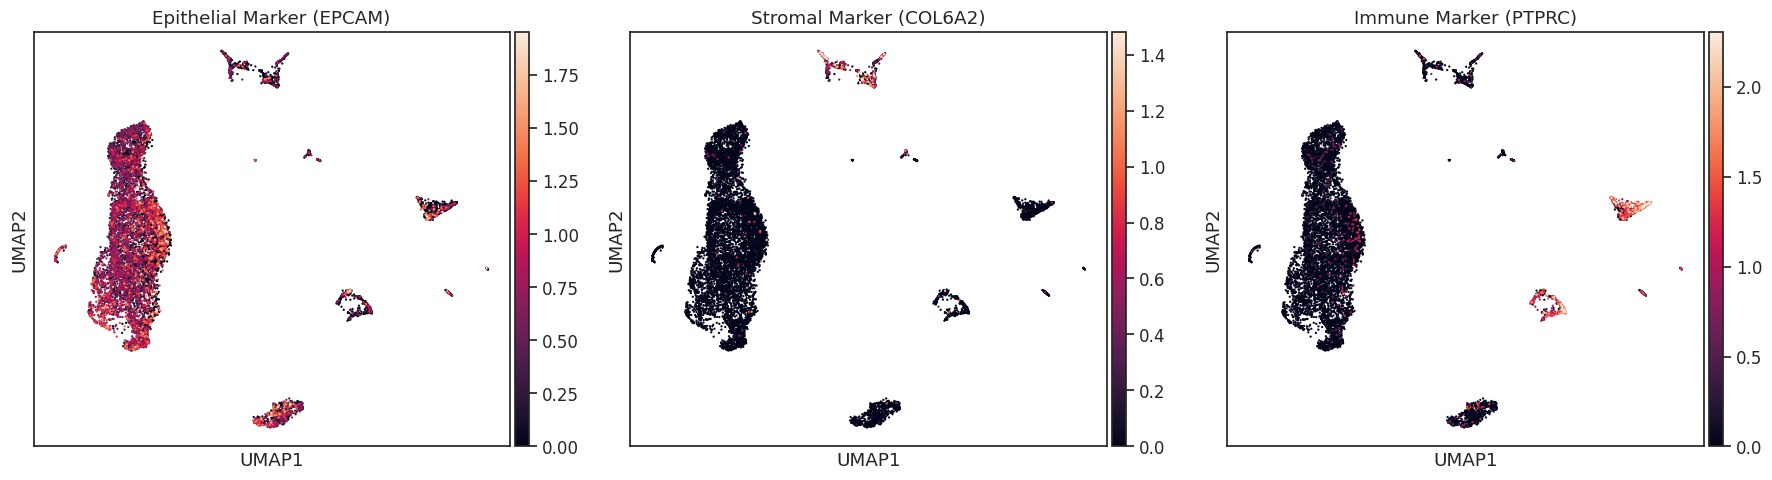

In [55]:
# Plot UMAPs for marker genes
fig = plot_umap_markers(normal_colon_adata, colon_marker_genes_for_umap, n_cols=3)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "normal_colon_marker_gene_umaps.png"),
    bbox_inches="tight",
)

##### Normal Colon Cell Type by Protocol (Percentage)

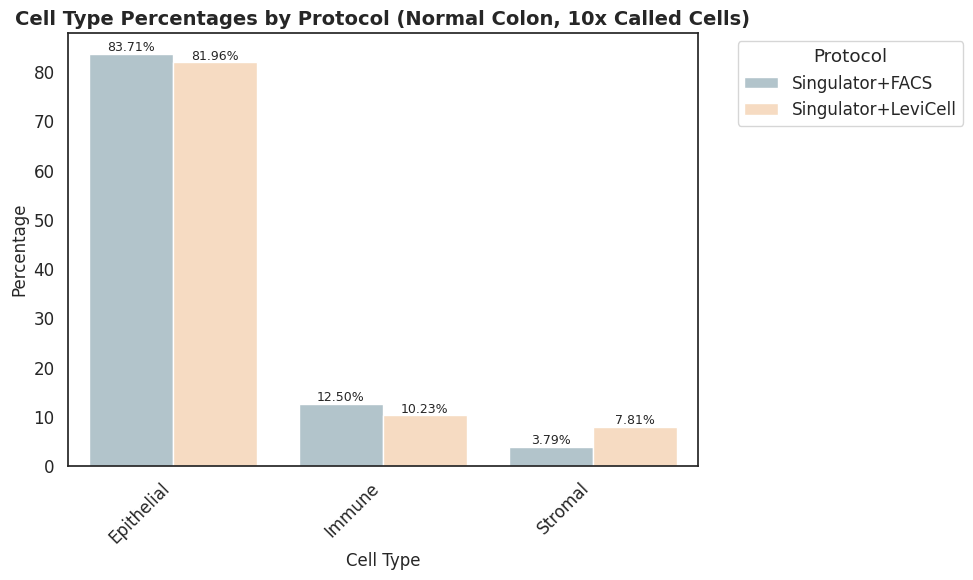

In [ ]:
# Plot cell type proportions by protocol for Normal Colon
fig = utils.plot_celltype_proportions_by_protocol(
    adata=normal_colon_adata,
    tissue="Normal Colon",
    protocol_color_palette=protocol_color_palette,
    annotate=True,
    metric="predicted_cell_type",
    percentage=True,
    title="Cell Type Percentages by Protocol (Normal Colon, 10x Called Cells)",
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "normal_colon_cell_type_proportions.png"),
    bbox_inches="tight",
)

##### Normal Liver Cell Type by Protocol (Total Counts)

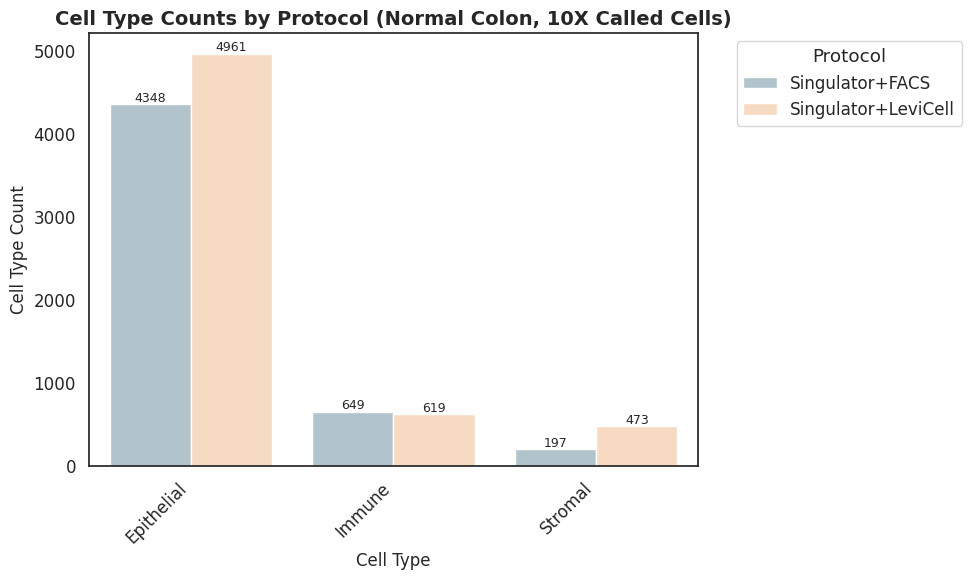

In [ ]:
# Plot cell type proportions by protocol for Normal Colon
fig = utils.plot_celltype_proportions_by_protocol(
    adata=normal_colon_adata,
    tissue="Normal Colon",
    protocol_color_palette=protocol_color_palette,
    annotate=True,
    metric="predicted_cell_type",
    percentage=False,
    title="Cell Type Counts by Protocol (Normal Colon, 10X Called Cells)"
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "normal_colon_cell_type_proportions.png"),
    bbox_inches="tight",
)

##### Write Updated AnnData to file

In [ ]:
normal_colon_adata_output_file_path = os.path.join(
    output_adata_dir, "Normal_Colon_combined_adata_clusters_removed_with_cell_type.h5ad"
)

# Write the updated AnnData to file
normal_colon_adata.write(normal_colon_adata_output_file_path)

print(f"Updated AnnData with cell type predictions saved to {normal_colon_adata_output_file_path}")

### Tissue 3: Tumor Colon

Since there is no matching CellTypist model for this tissue, we'll be performing out own manual cell typing for this tissue. Be sure to confirm from this analysis make sense. We will also perform inferCNVpy on this tissue in order to identify putative tumor epithelial cells and determine which protocol does better tumor cell capture.

... storing 'predicted_cell_type' as categorical


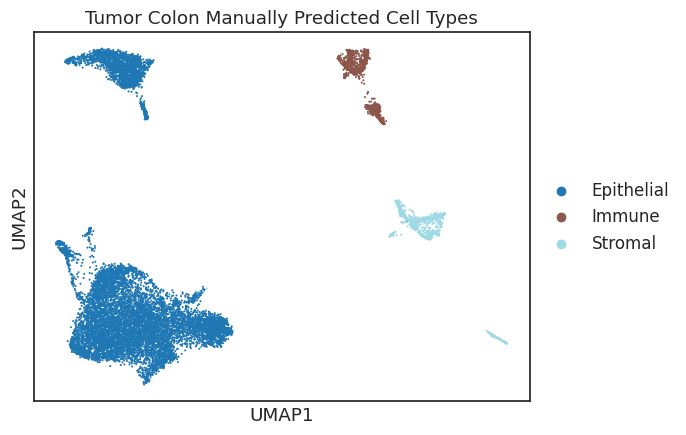

In [57]:
# Get the Tumor Colon AnnData
tumor_colon_adata = combined_by_tissue_adata_dict["Tumor Colon"].copy()

# Assign cell types to the colon adata
assign_celltypes_by_cluster_avg_expression(
    adata=tumor_colon_adata,
    cell_marker_genes=colon_marker_dict,
    cluster_key="leiden",
)

# Plot UMAP with predicted cell types for Tumor Colon
sc.pl.umap(
    tumor_colon_adata,
    color="predicted_cell_type",
    title="Tumor Colon Manually Predicted Cell Types",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
)

#### Add Leiden Cluster + Predicted Cell Type Column and Sort for Dotplot

In [58]:
tumor_colon_adata.obs["leiden_cell_type"] = (
    tumor_colon_adata.obs["leiden"].astype(str)
    + " ("
    + tumor_colon_adata.obs["predicted_cell_type"].astype(str)
    + ")"
)


current_categories = tumor_colon_adata.obs["leiden_cell_type"].unique()
sorted_categories = sorted(current_categories, key=sort_key)
tumor_colon_adata.obs["leiden_cell_type"] = pd.Categorical(
    tumor_colon_adata.obs["leiden_cell_type"],
    categories=sorted_categories,
    ordered=True,
)


##### Tumor Colon Dotplot

Cell type 'Immune': Missing genes -> ['CD3E', 'CD3D', 'CD3G']


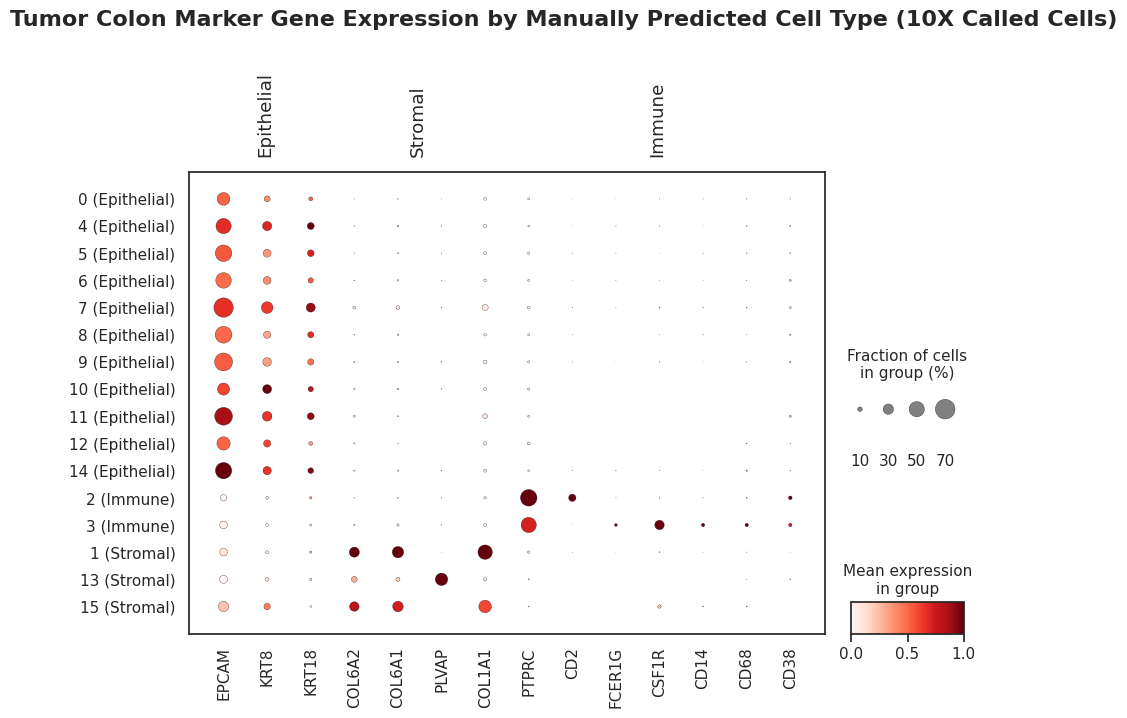

In [59]:
filtered_colon_marker_dict = filter_marker_genes_by_adata(
    marker_dict=colon_marker_dict,
    adata=tumor_colon_adata,
)

# Create the dotplot
tumor_colon_dp = sc.pl.dotplot(
    tumor_colon_adata,
    var_names=filtered_colon_marker_dict,
    groupby="leiden_cell_type",
    standard_scale="var",
    color_map="Reds",
    figsize=(10, 6),
    dendrogram=False,
    show=False,
    return_fig=True,
)

# Set title and adjust layout
fig = tumor_colon_dp.get_axes()["mainplot_ax"].figure
fig.suptitle(
    "Tumor Colon Marker Gene Expression by Manually Predicted Cell Type (10X Called Cells)",
    fontsize=16,
    weight="bold",
    y=1.15,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
fig.savefig(os.path.join(figures_output_dir, "tumor_colon_marker_gene_dotplot.png"))

##### Tumor Colon Marker Gene Heatmap

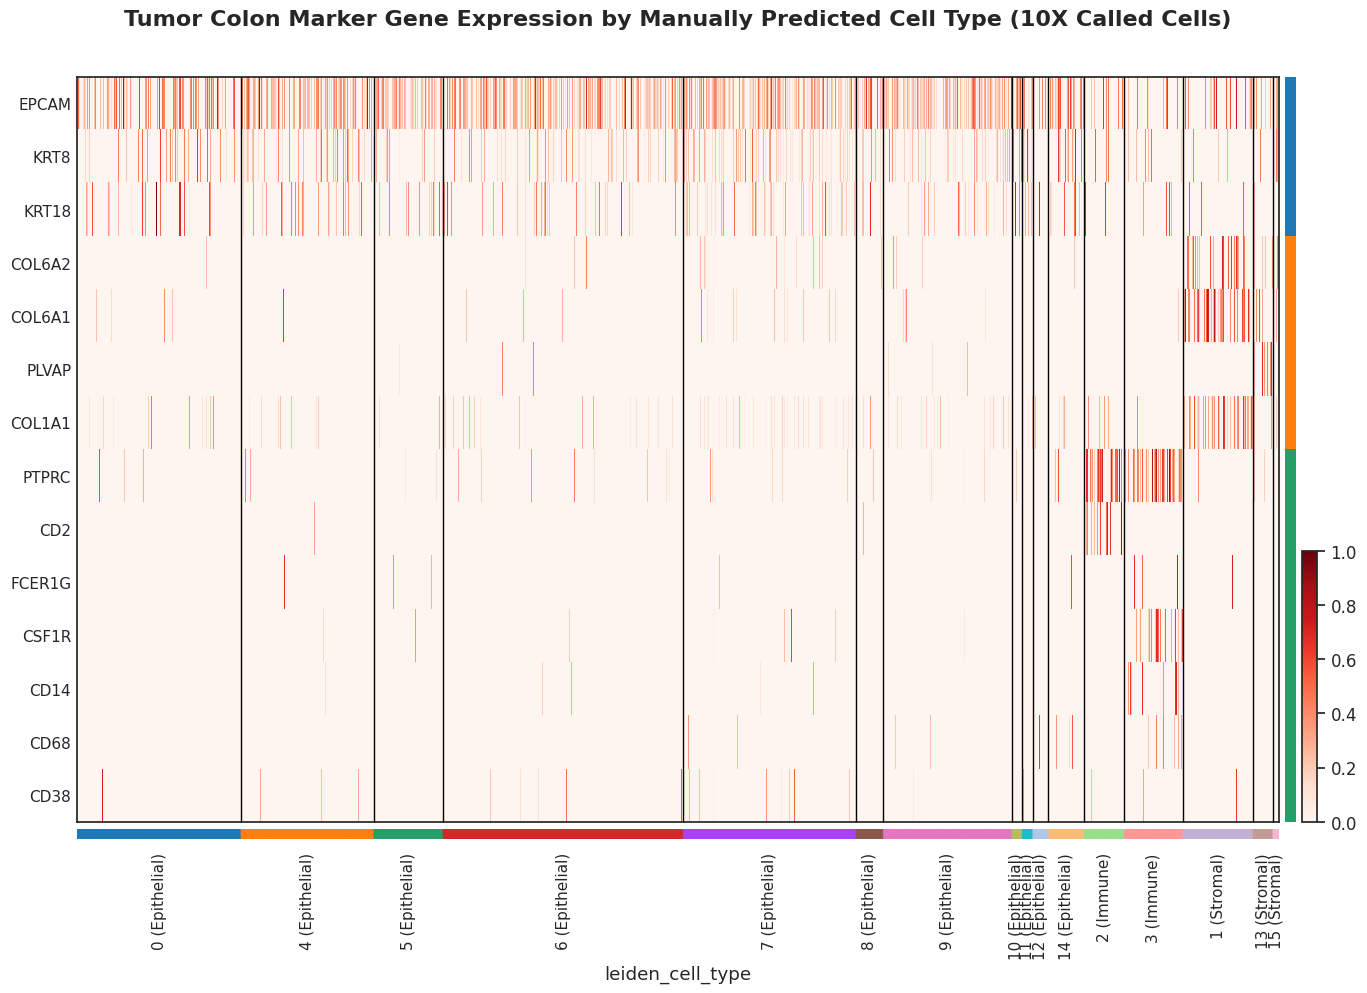

In [61]:
# Create and store the heatmap object
tumor_colon_hm = sc.pl.heatmap(
    tumor_colon_adata,
    var_names=filtered_colon_marker_dict,
    groupby="leiden_cell_type",
    standard_scale="var",
    cmap="Reds",
    swap_axes=True,
    show_gene_labels=True,
    var_group_labels=filtered_colon_marker_dict.keys(),
    var_group_rotation=45,
    dendrogram=False,
    figsize=(16, 10),
    show=False,
)

# Use any axis to get the figure
fig = next(iter(tumor_colon_hm.values())).figure

# Set suptitle and adjust layout
fig.suptitle(
    "Tumor Colon Marker Gene Expression by Manually Predicted Cell Type (10X Called Cells)",
    fontsize=16,
    weight="bold",
    y=0.94,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "tumor_colon_marker_gene_heatmap.png"),
    bbox_inches="tight",
)

#### Plot Marker Gene Expression UMAPs

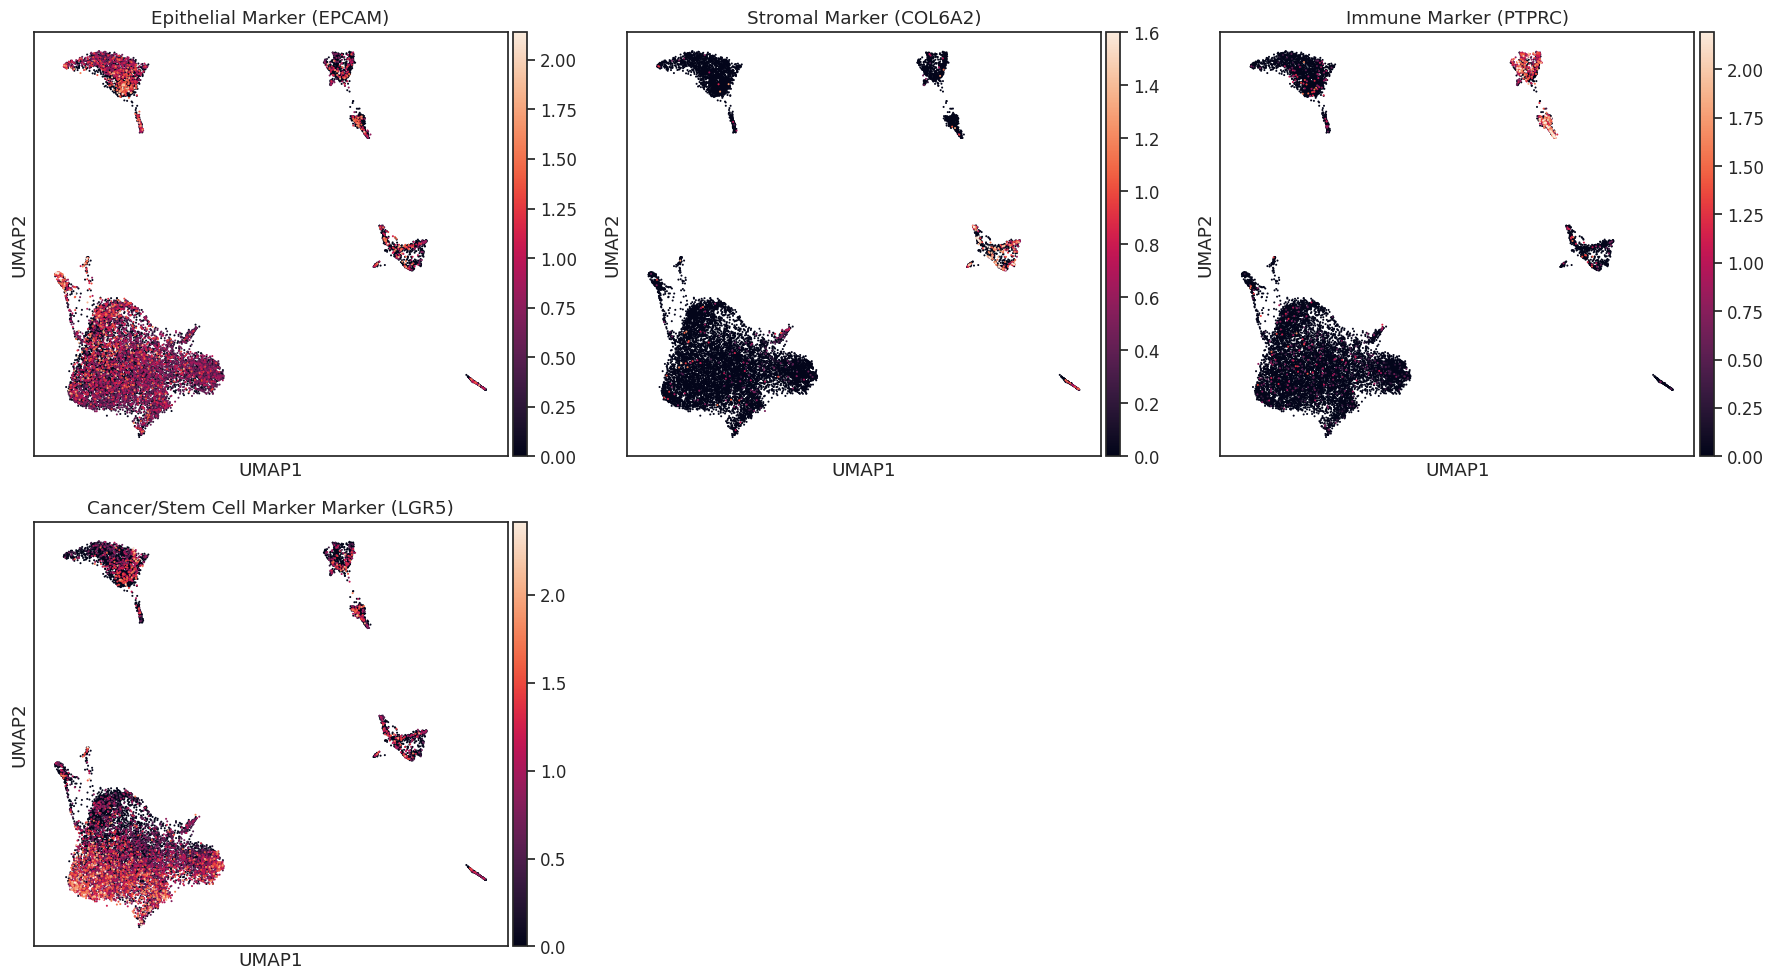

In [64]:
# Plot UMAPs for marker genes
fig = plot_umap_markers(tumor_colon_adata, colon_marker_genes_for_umap, n_cols=3)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "tumor_colon_marker_gene_umaps.png"),
    bbox_inches="tight",
)

##### Tumor Colon Cell Type by Protocol (Percentage)

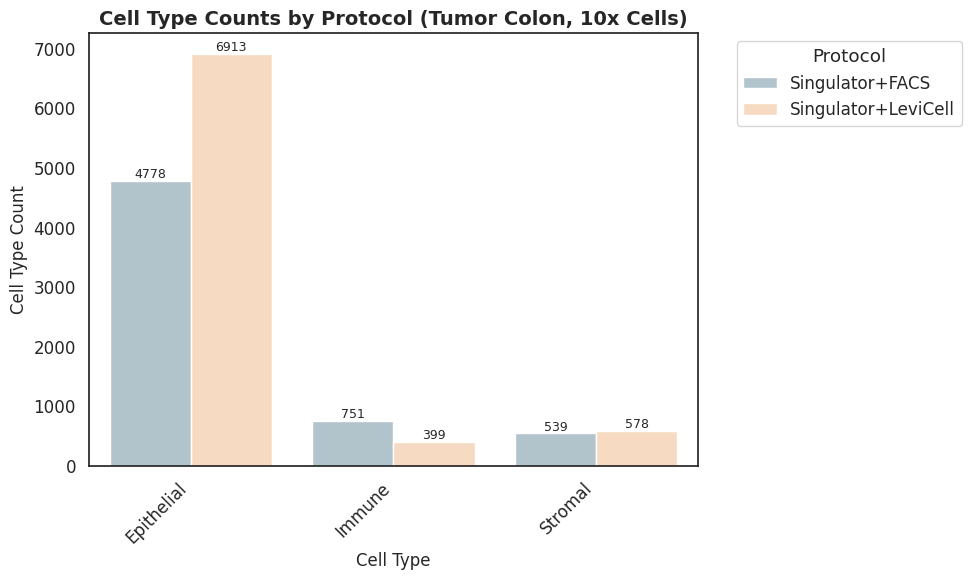

In [65]:
# Plot cell type proportions by protocol for Tumor Colon
fig = utils.plot_celltype_proportions_by_protocol(
    adata=tumor_colon_adata,
    tissue="Tumor Colon",
    protocol_color_palette=protocol_color_palette,
    annotate=True,
    metric="predicted_cell_type",
    percentage=False,
    title="Cell Type Counts by Protocol (Tumor Colon, 10x Cells)"
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "tumor_colon_cell_type_proportions.png"),
    bbox_inches="tight",
)

### Tumor Colon InferCNV

#### Functions
- parse_gtf_with_combined_lookup: Parses a GTF file and returns a pandas dataframe with gene ID (Ensembl) and matching gene symbol

In [67]:
def convert_gtf_to_dataframe(gtf_path : str) -> pd.DataFrame:
    """Parse GTF and return DataFrame with combined gene_id and gene_name indexing."""
    records = []
    with gzip.open(gtf_path, "rt") if gtf_path.endswith(".gz") else open(gtf_path) as f:
        for line in f:
            if line.startswith("#"):
                continue
            fields = line.strip().split("\t")
            if fields[2] != "gene":
                continue

            chrom, start, end, attributes = (
                fields[0],
                int(fields[3]),
                int(fields[4]),
                fields[8],
            )
            attr_dict = {
                k.strip(): v.strip('"')
                for attr in attributes.strip().split(";")
                if attr.strip()
                for k, v in [attr.strip().split(" ", 1)]
            }

            gene_id = attr_dict.get("gene_id")
            gene_name = attr_dict.get("gene_name")
            if gene_id and gene_name:
                records.append((gene_id, gene_name, chrom, start, end))

    df = pd.DataFrame(
        records, columns=["gene_id", "gene_name", "chromosome", "start", "end"]
    )

    # Two dataframes for matching
    by_id = df.drop_duplicates("gene_id").set_index("gene_id")
    by_name = df.drop_duplicates("gene_name").set_index("gene_name")

    # Merge on outer keys (index), prefer Ensembl ID matches but fill from gene symbol if missing
    gtf_df = by_id.combine_first(by_name)

    return gtf_df

#### Get Gene Coordinates from GTF

In [ ]:
# Get file path from config
gene_set_info_dir = config.GENE_SET_INFO_DIR
gtf_file_name = "Homo_sapiens.GRCh38.114.gtf.gz"

# Load gene coordinates from GTF
gene_coords = convert_gtf_to_dataframe(os.path.join(gene_set_info_dir, gtf_file_name))

# Match to adata.var_names (can be mix of gene symbols and Ensembl IDs)
matched = gene_coords.reindex(tumor_colon_adata.var_names)

# Add gene coordinate information to the AnnData object
tumor_colon_adata.var["chromosome"] = "chr" + matched["chromosome"].fillna("NA").astype(
    str
)
tumor_colon_adata.var["start"] = matched["start"].astype("Int64")
tumor_colon_adata.var["end"] = matched["end"].astype("Int64")

##### Filter Chromsomes to only Include Autosomes + Chr23

In [32]:
# Define valid chromosomes: chr1 to chr23 (autosomes + chr23)
valid_chroms = {f"chr{i}" for i in range(1, 24)}

# Create mask for genes on valid chromosomes
valid_mask = tumor_colon_adata.var["chromosome"].isin(valid_chroms)

# Subset AnnData
tumor_colon_adata = tumor_colon_adata[:, valid_mask].copy()

#### Run InferCNVpy

In [33]:
cnv.tl.infercnv(
    tumor_colon_adata,
    reference_key="predicted_cell_type",
    reference_cat=["Immune", "Stromal"],
)

  0%|          | 0/3 [00:00<?, ?it/s]

##### Construct Heatmap

Groups are not reordered because the `groupby` categories and the `var_group_labels` are different.
categories: 0 (Epithelial), 4 (Epithelial), 5 (Epithelial), etc.
var_group_labels: chr1, chr2, chr3, etc.


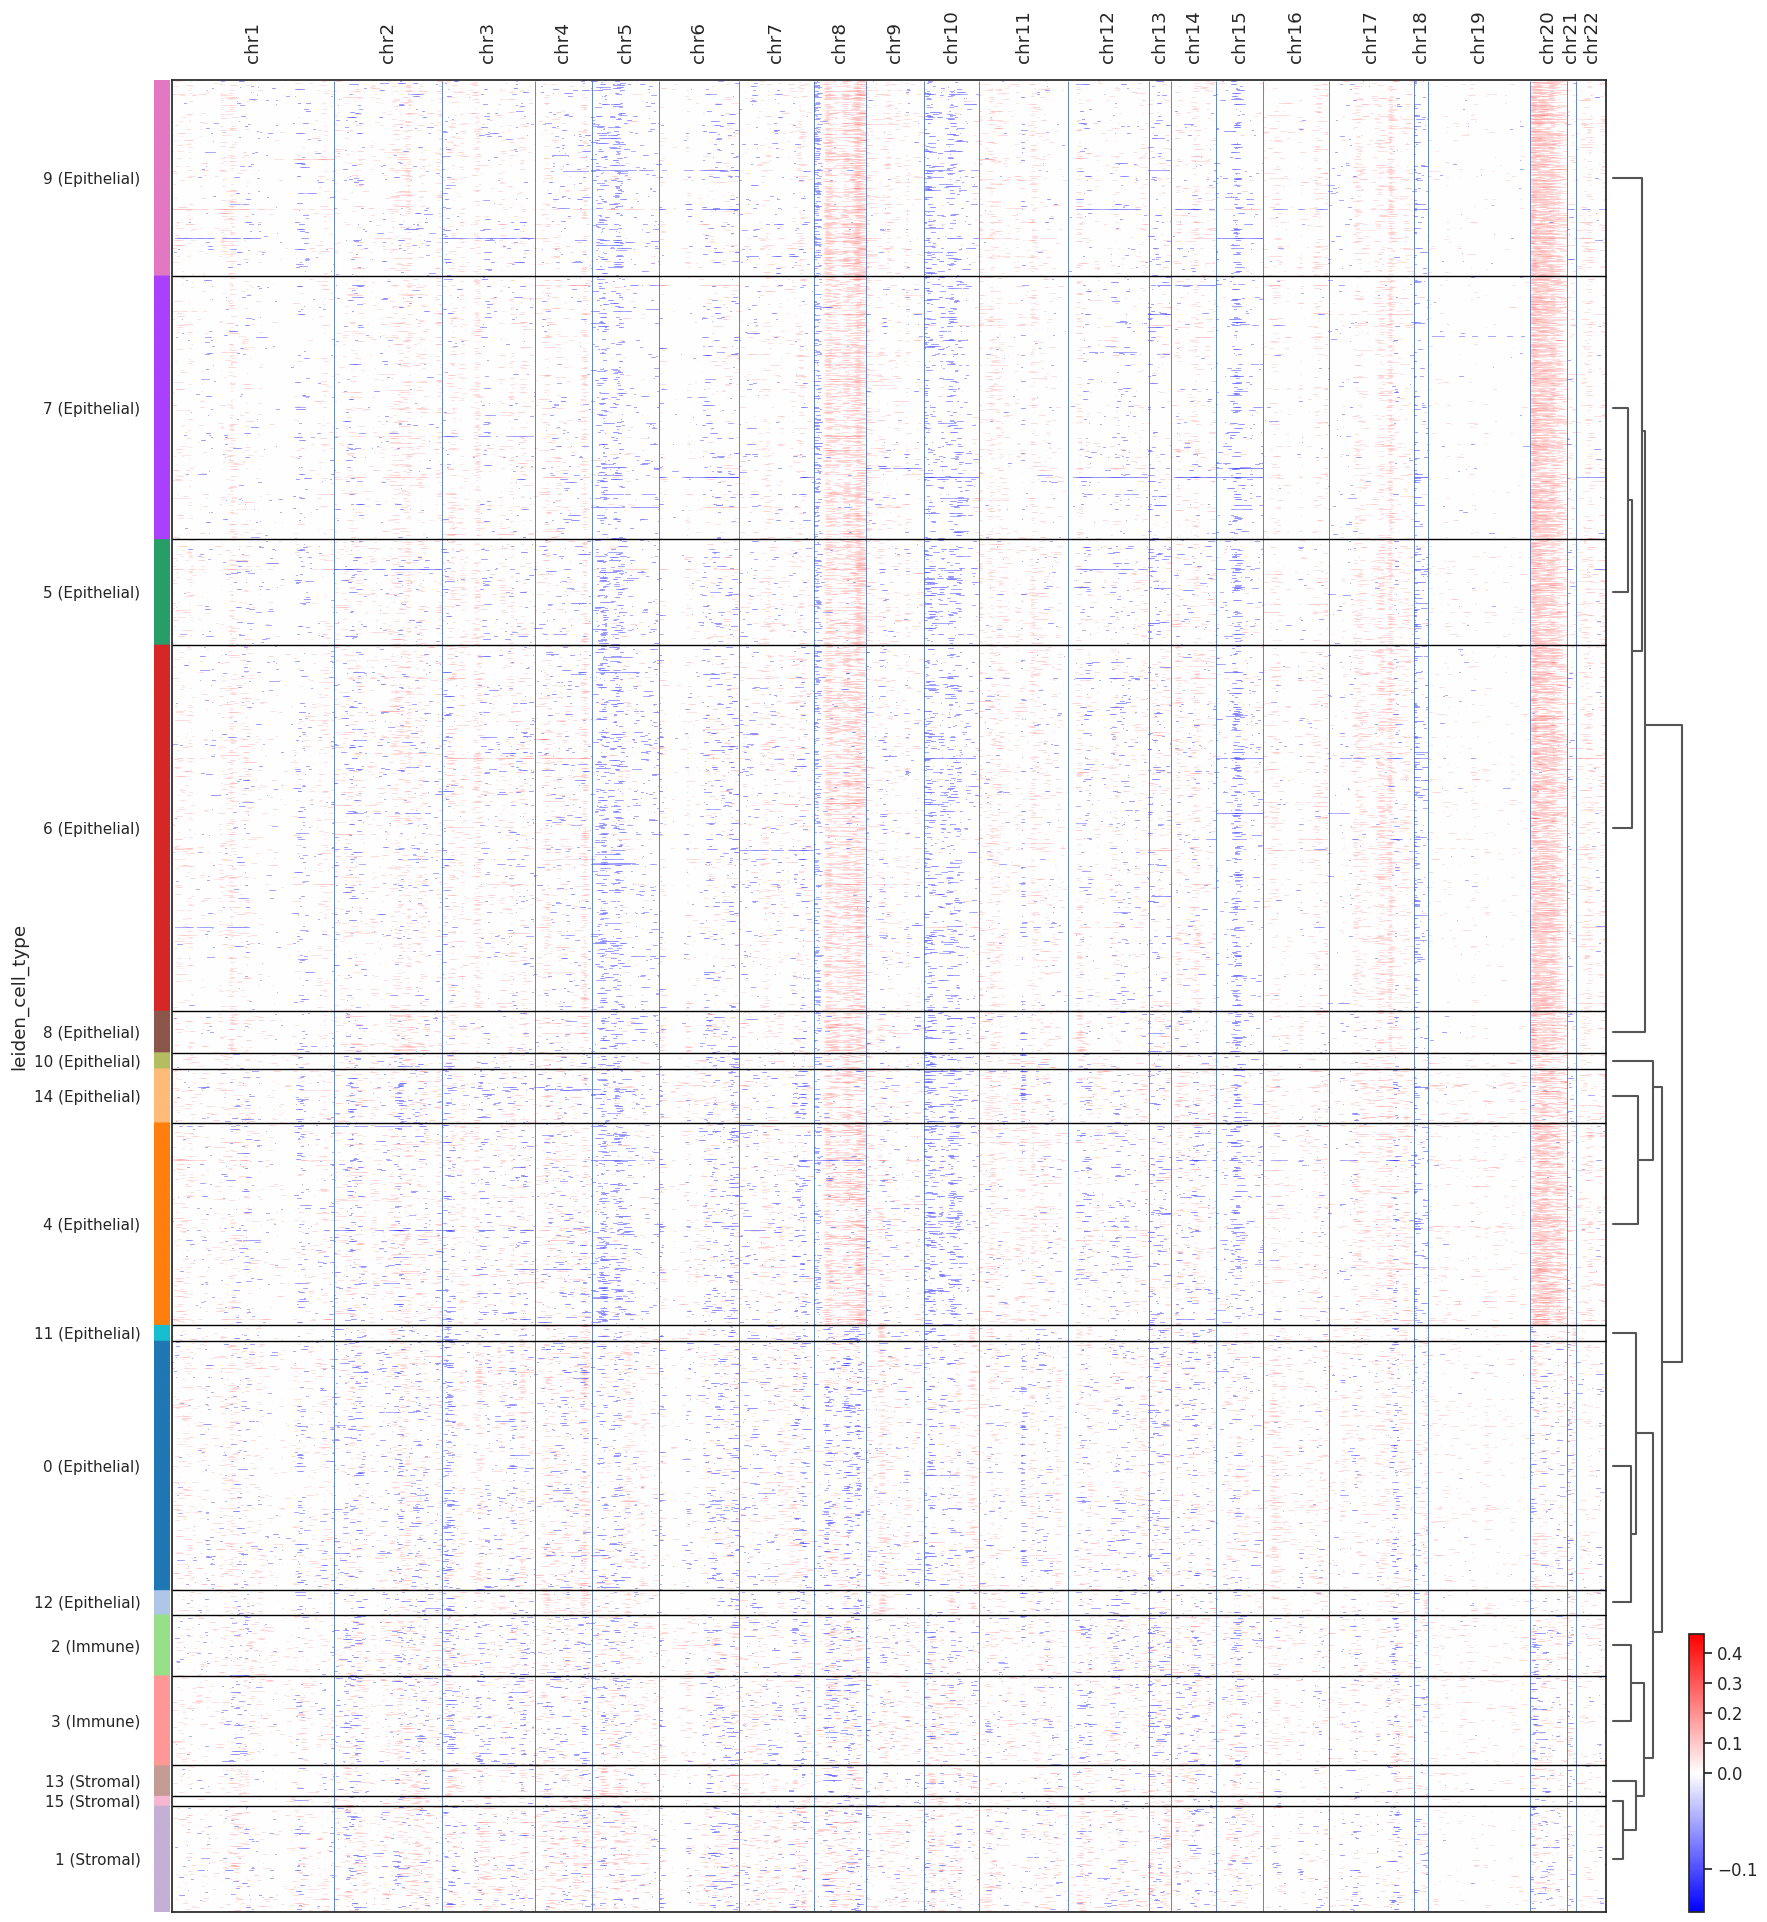

In [34]:
sc.tl.dendrogram(
    tumor_colon_adata,
    groupby="leiden_cell_type",
    optimal_ordering=True,
    inplace=True,
    use_raw=False,
)
cnv.pl.chromosome_heatmap(
    tumor_colon_adata, groupby="leiden_cell_type", figsize=(20, 24), dendrogram=True
)

### Run Graph Computation on CNV Data

In [68]:
cnv.tl.pca(tumor_colon_adata)
cnv.pp.neighbors(tumor_colon_adata)
cnv.tl.leiden(tumor_colon_adata)

KeyError: 'X_cnv is not in adata.obsm. Did you run `tl.infercnv`?'

##### Plot UMAPs based on CNV Graphs

... storing 'chromosome' as categorical


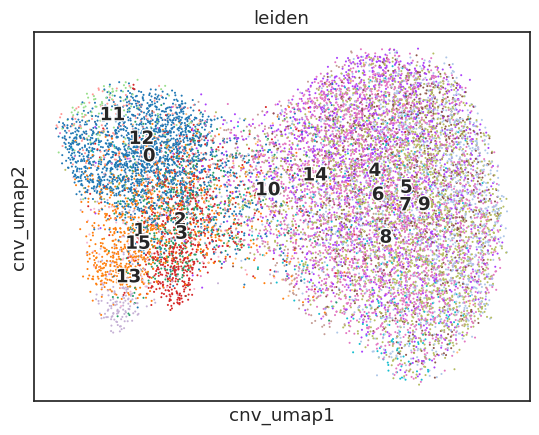

In [ ]:
cnv.tl.umap(tumor_colon_adata)
cnv.tl.cnv_score(tumor_colon_adata)

cnv.pl.umap(
    tumor_colon_adata,
    color="leiden",
    legend_loc="on data",
    legend_fontoutline=2,
)

##### Plot CNV Scores (measure of copy number variation by cluster)

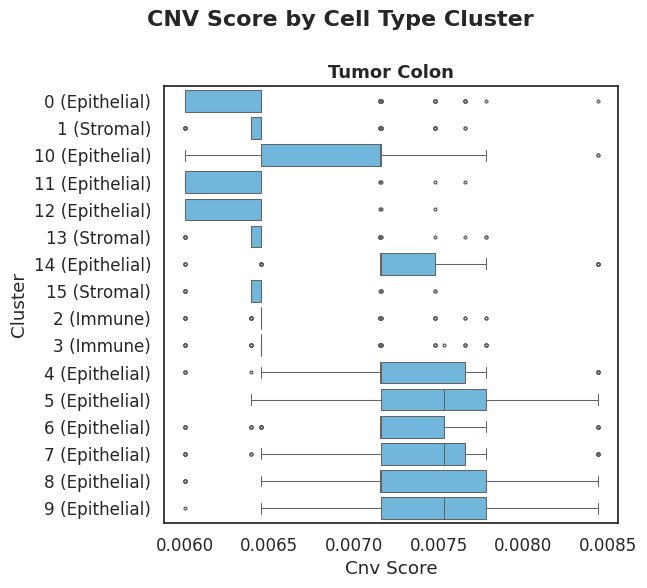

In [ ]:
# Plot CNV score by cell type cluster
fig = utils.plot_cluster_metric_boxplots(
    combined_by_tissue={"Tumor Colon": tumor_colon_adata},
    cluster_key="leiden_cell_type",
    metric="cnv_score",
    vertical=True,
    title="CNV Score by Cell Type Cluster",
)

#### Annotate AnnData based on Putative Tumor Stats

In [ ]:
putative_tumor_clusters = ["0", "11", "12"]

# Start with predicted cell type
tumor_colon_adata.obs["putative_tumor"] = tumor_colon_adata.obs["predicted_cell_type"]
tumor_colon_adata.obs["putative_tumor"] = tumor_colon_adata.obs[
    "putative_tumor"
].astype(str)

# Boolean mask: Epithelial & in tumor clusters
mask = (tumor_colon_adata.obs["predicted_cell_type"] == "Epithelial") & (
    ~tumor_colon_adata.obs["leiden"].isin(putative_tumor_clusters)
)

# Append " (Tumor)" only where mask is True
tumor_colon_adata.obs.loc[mask, "putative_tumor"] = (
    tumor_colon_adata.obs.loc[mask, "putative_tumor"] + " (Tumor)"
)

#### Updated Tumor Colon Cell Type by Protocol (Percentage)

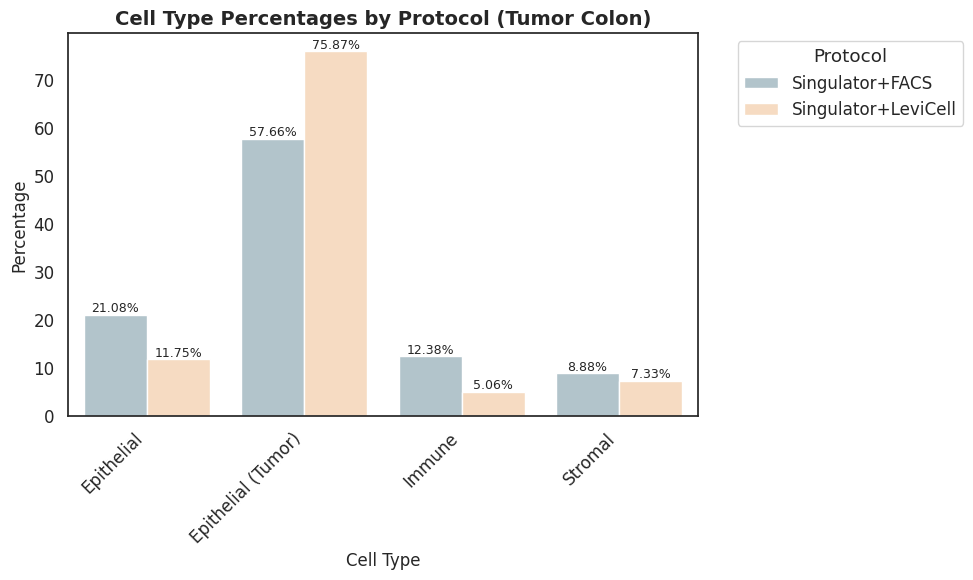

In [ ]:
# Plot cell type proportions by protocol for Tumor Colon
fig = utils.plot_celltype_proportions_by_protocol(
    adata=tumor_colon_adata,
    tissue="Tumor Colon",
    protocol_color_palette=protocol_color_palette,
    annotate=True,
    metric="putative_tumor",
    percentage=True,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "tumor_colon_cell_type_proportions.png"),
    bbox_inches="tight",
)

#### Updated Tumor Colon Cell Type by Protocol (Total Counts)

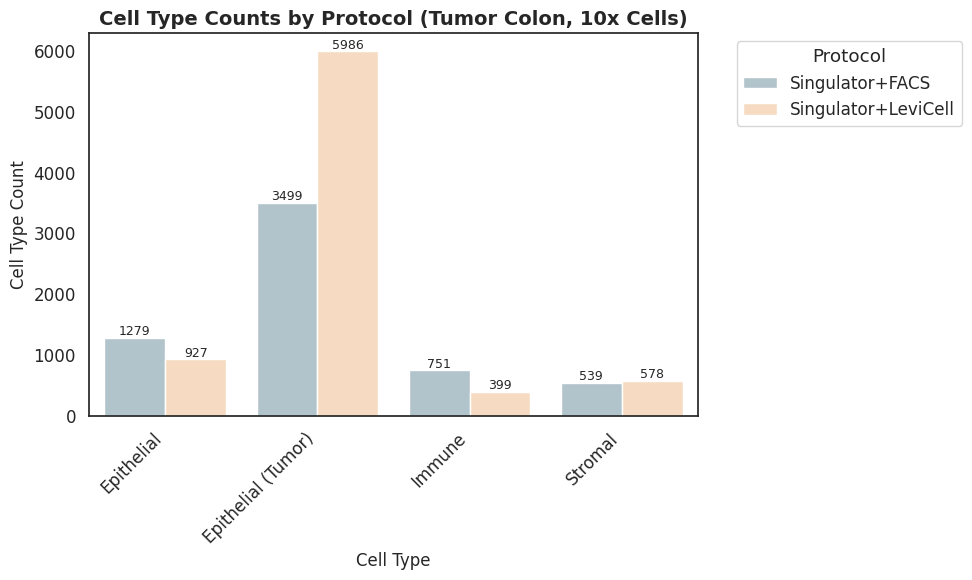

In [ ]:
# Plot cell type proportions by protocol for Tumor Colon
fig = utils.plot_celltype_proportions_by_protocol(
    adata=tumor_colon_adata,
    tissue="Tumor Colon",
    protocol_color_palette=protocol_color_palette,
    annotate=True,
    metric="putative_tumor",
    percentage=False,
    title="Cell Type Counts by Protocol (Tumor Colon, 10x Cells)"
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "tumor_colon_cell_type_proportions.png"),
    bbox_inches="tight",
)

##### Write Updated AnnData to file

In [ ]:
tumor_colon_adata_output_file_path = os.path.join(
    output_adata_dir, "Tumor_Colon_combined_adata_clusters_removed_with_cell_type.h5ad"
)

# Write the updated AnnData to file
tumor_colon_adata.write(tumor_colon_adata_output_file_path)

print(f"Updated Tumor Colon AnnData with cell type predictions saved to {liver_adata_output_file_path}")